# Setup

## Imports & Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Column Names (from Metadata & To Be Created)
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_fff = "file_path"  # column in metadata in which to store data file path
col_cell_type = "Annotation"  # for eventual cluster annotation column
col_tangram = "tangram_prediction"  # for future Tangram imputation annotation

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options & Data

In [27]:
# Directories & Metadata
load, reannotate = True, True
# run = "CHO-001"
run = ["CHO-001", "CHO-002", "CHO-005", "CHO-006"]
# samples = "all"
# samples = ["50007B2"]
# samples = ["50452A"]
samples = ["50452B"]
# samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5"]

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata0/xenium"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = os.path.join(ddm, "disk2" if "cho" in ddm else "",
                      os.getlogin(), "data")  # other, e.g., Tangram data
anf = pd.read_csv(os.path.join(ddu, "corescpy/examples/markers_lineages.csv"))
file_mdf = os.path.join(ddl, "Xenium_Samples_03152024.xlsx")  # metadata

# Annotation & Tangram Imputation
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"
# file_sc = None  # to skip Tangram imputation/label transfer

# Processing & Clustering Options
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[10, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm="log")  # preprocessing keyword arguments
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=list(anf.iloc[:, 0]),  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
kws_clustering, col_assignment = {}, []
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})
    col_assignment += ["group" if kws["resolution"] >= 0.7 else "Bucket"]

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
metadata = pd.read_excel(file_mdf, dtype={"Slide ID": str}).rename(
    {"Name": col_subject, "Inflammation Status": col_inflamed}, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(cr.pp.construct_file(run=run, directory=ddx))
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    metadata.loc[metadata[col_sample_id_o] == x, col_fff] = fff[np.where(
        samps == x)[0][0]] if len(np.where(samps == x)[0]) > 0 else np.nan
metadata = metadata.dropna(subset=[col_fff])

# Annotation File
assign = anf.dropna(subset=col_assignment).rename_axis("Gene")  # markers
assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers
marker_genes_dict = dict(assign["Bucket"].reset_index().groupby(
    "Bucket").apply(lambda x: list(pd.unique(x.Gene))))  # to dictionary

# Print Metadata & Make Output Directory (If Not Present)
print(metadata)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load Data
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cell_type)  # object creation arguments
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    selves[i] = cr.Spatial(metadata.loc[x][col_fff], library_id=x, **kws_init)
    for j in metadata:  # iterate metadata columns
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])  # add to object
    selves[i].rna.obs.loc[:, "out_file"] = os.path.join(
        out_dir, selves[0]._library_id)  # output path (to save object)
    if load is True:
        selves[i].update_from_h5ad(str(selves[0].rna.obs.out_file.iloc[0]))

                Sample ID  Patient     Status          Project  \
Sample                                                           
Inflamed-50452B    50452B    50452  Available  scRNA & Spatial   

                       Location Stricture  Inflamed  GRID ID Procedure Date  \
Sample                                                                        
Inflamed-50452B  Terminal Ileum        no  Inflamed  1011335        2023-12   

                 Age     Sex   Race Hispanic        Diagnosis  \
Sample                                                          
Inflamed-50452B   69  female  white       NO  Crohn's Disease   

                           Project.1  Procedure Disease_Status Date Collected  \
Sample                                                                          
Inflamed-50452B  Helmsley-Senescence  Resection         Active            NaN   

                Date Sectioned Date Hybridization Storage 4c     Created By  \
Sample                                      

# Clustering

## Processing, Leiden, Annotation



 {'cell_filter_pmt': None, 'cell_filter_ncounts': [50, None], 'cell_filter_ngene': [10, None], 'gene_filter_ncell': [3, None], 'gene_filter_ncounts': [3, None], 'custom_thresholds': None, 'kws_scale': {'max_value': 10, 'zero_center': True}, 'method_norm': 'log'} 


AnnData object with n_obs × n_vars = 276881 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file'
    var: 'gene_ids', 'feature_types', 'genome'
  

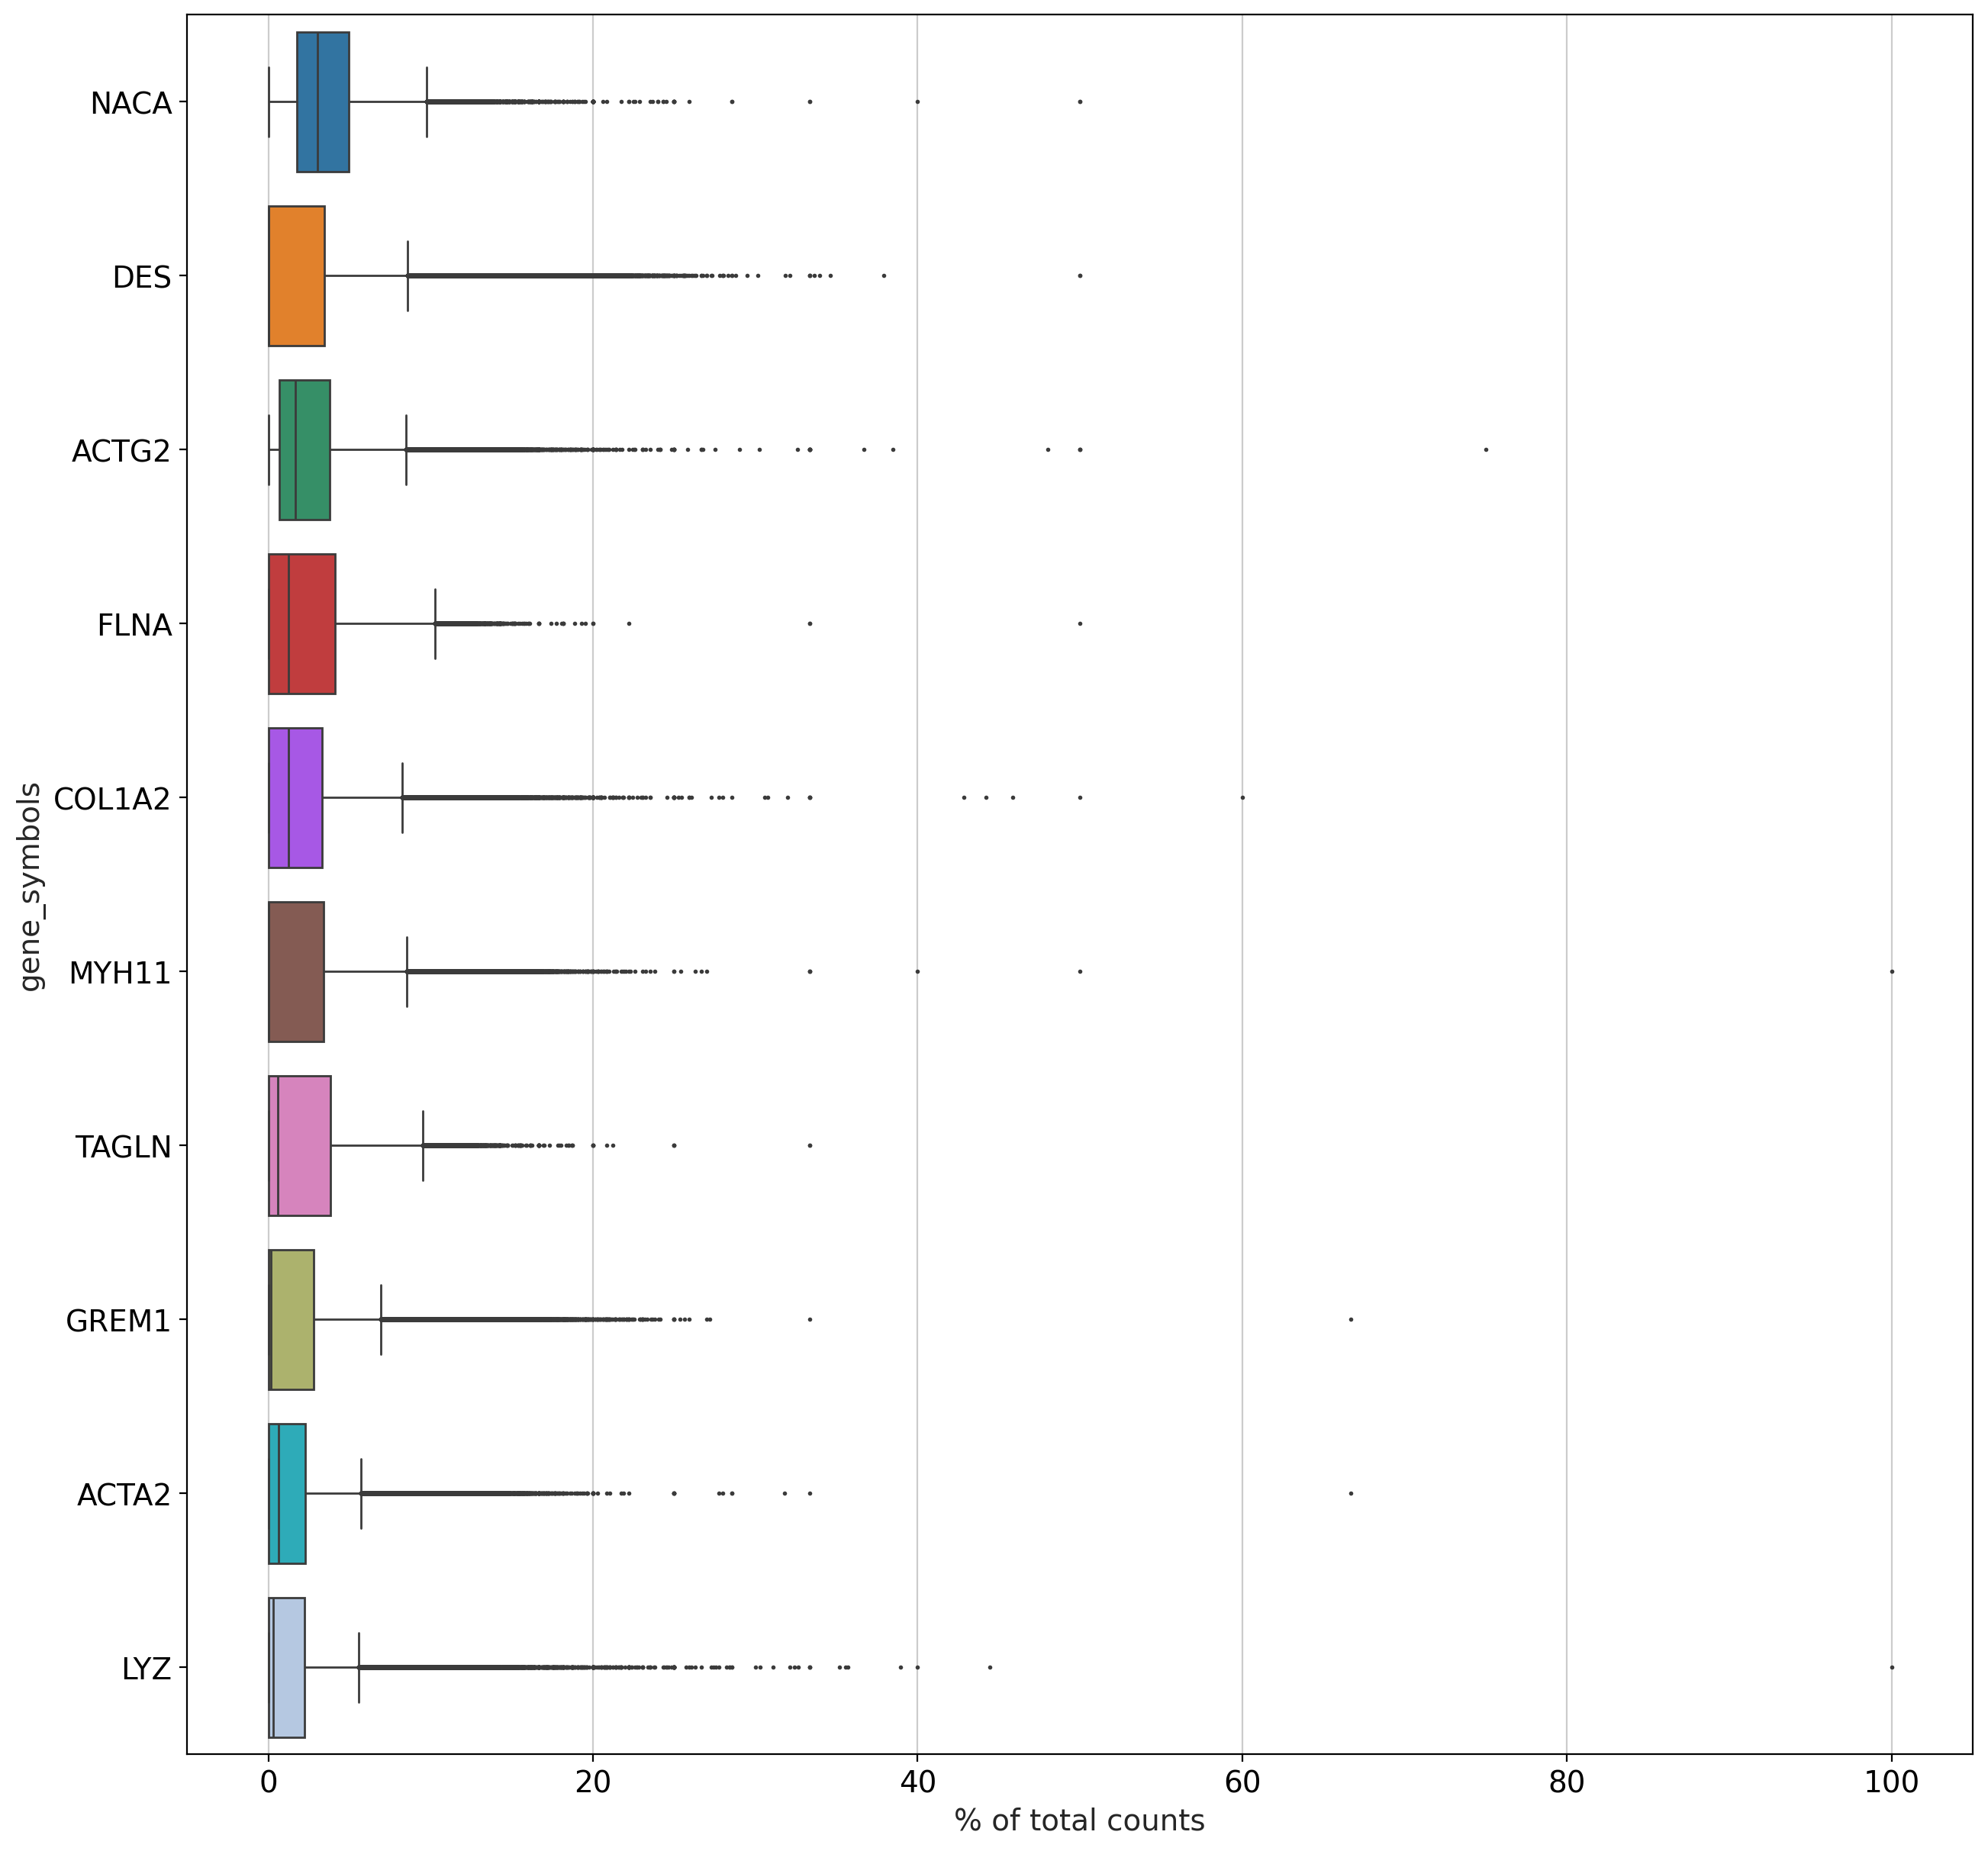

dsfasfda AnnData object with n_obs × n_vars = 276881 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file', 'n_counts', 'log_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts'


Cell Counts: Initial


Observations: 276881



Gene Counts: Initial

Empty DataFrame
Columns: [gene_symbols, gene_ids, feature

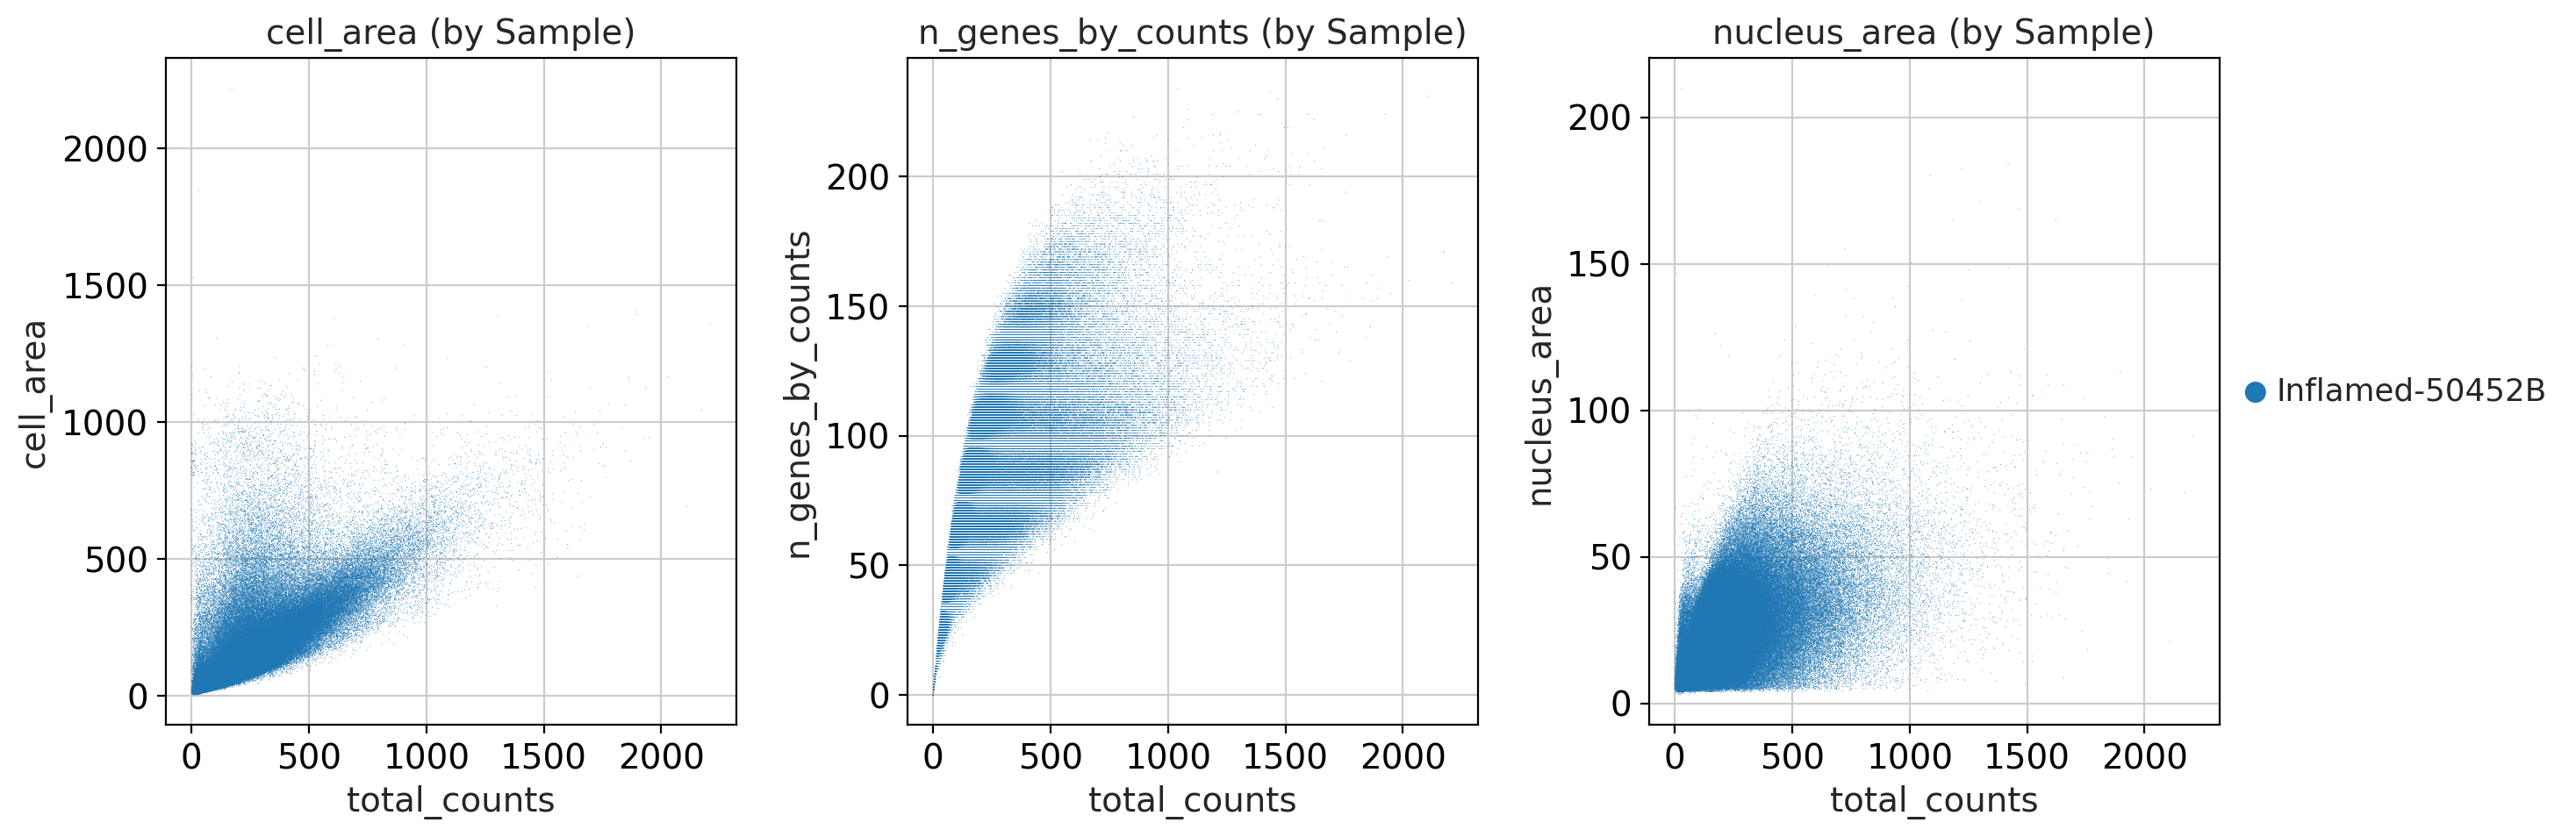


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>
dsfasfda AnnData object with n_obs × n_vars = 276115 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropou

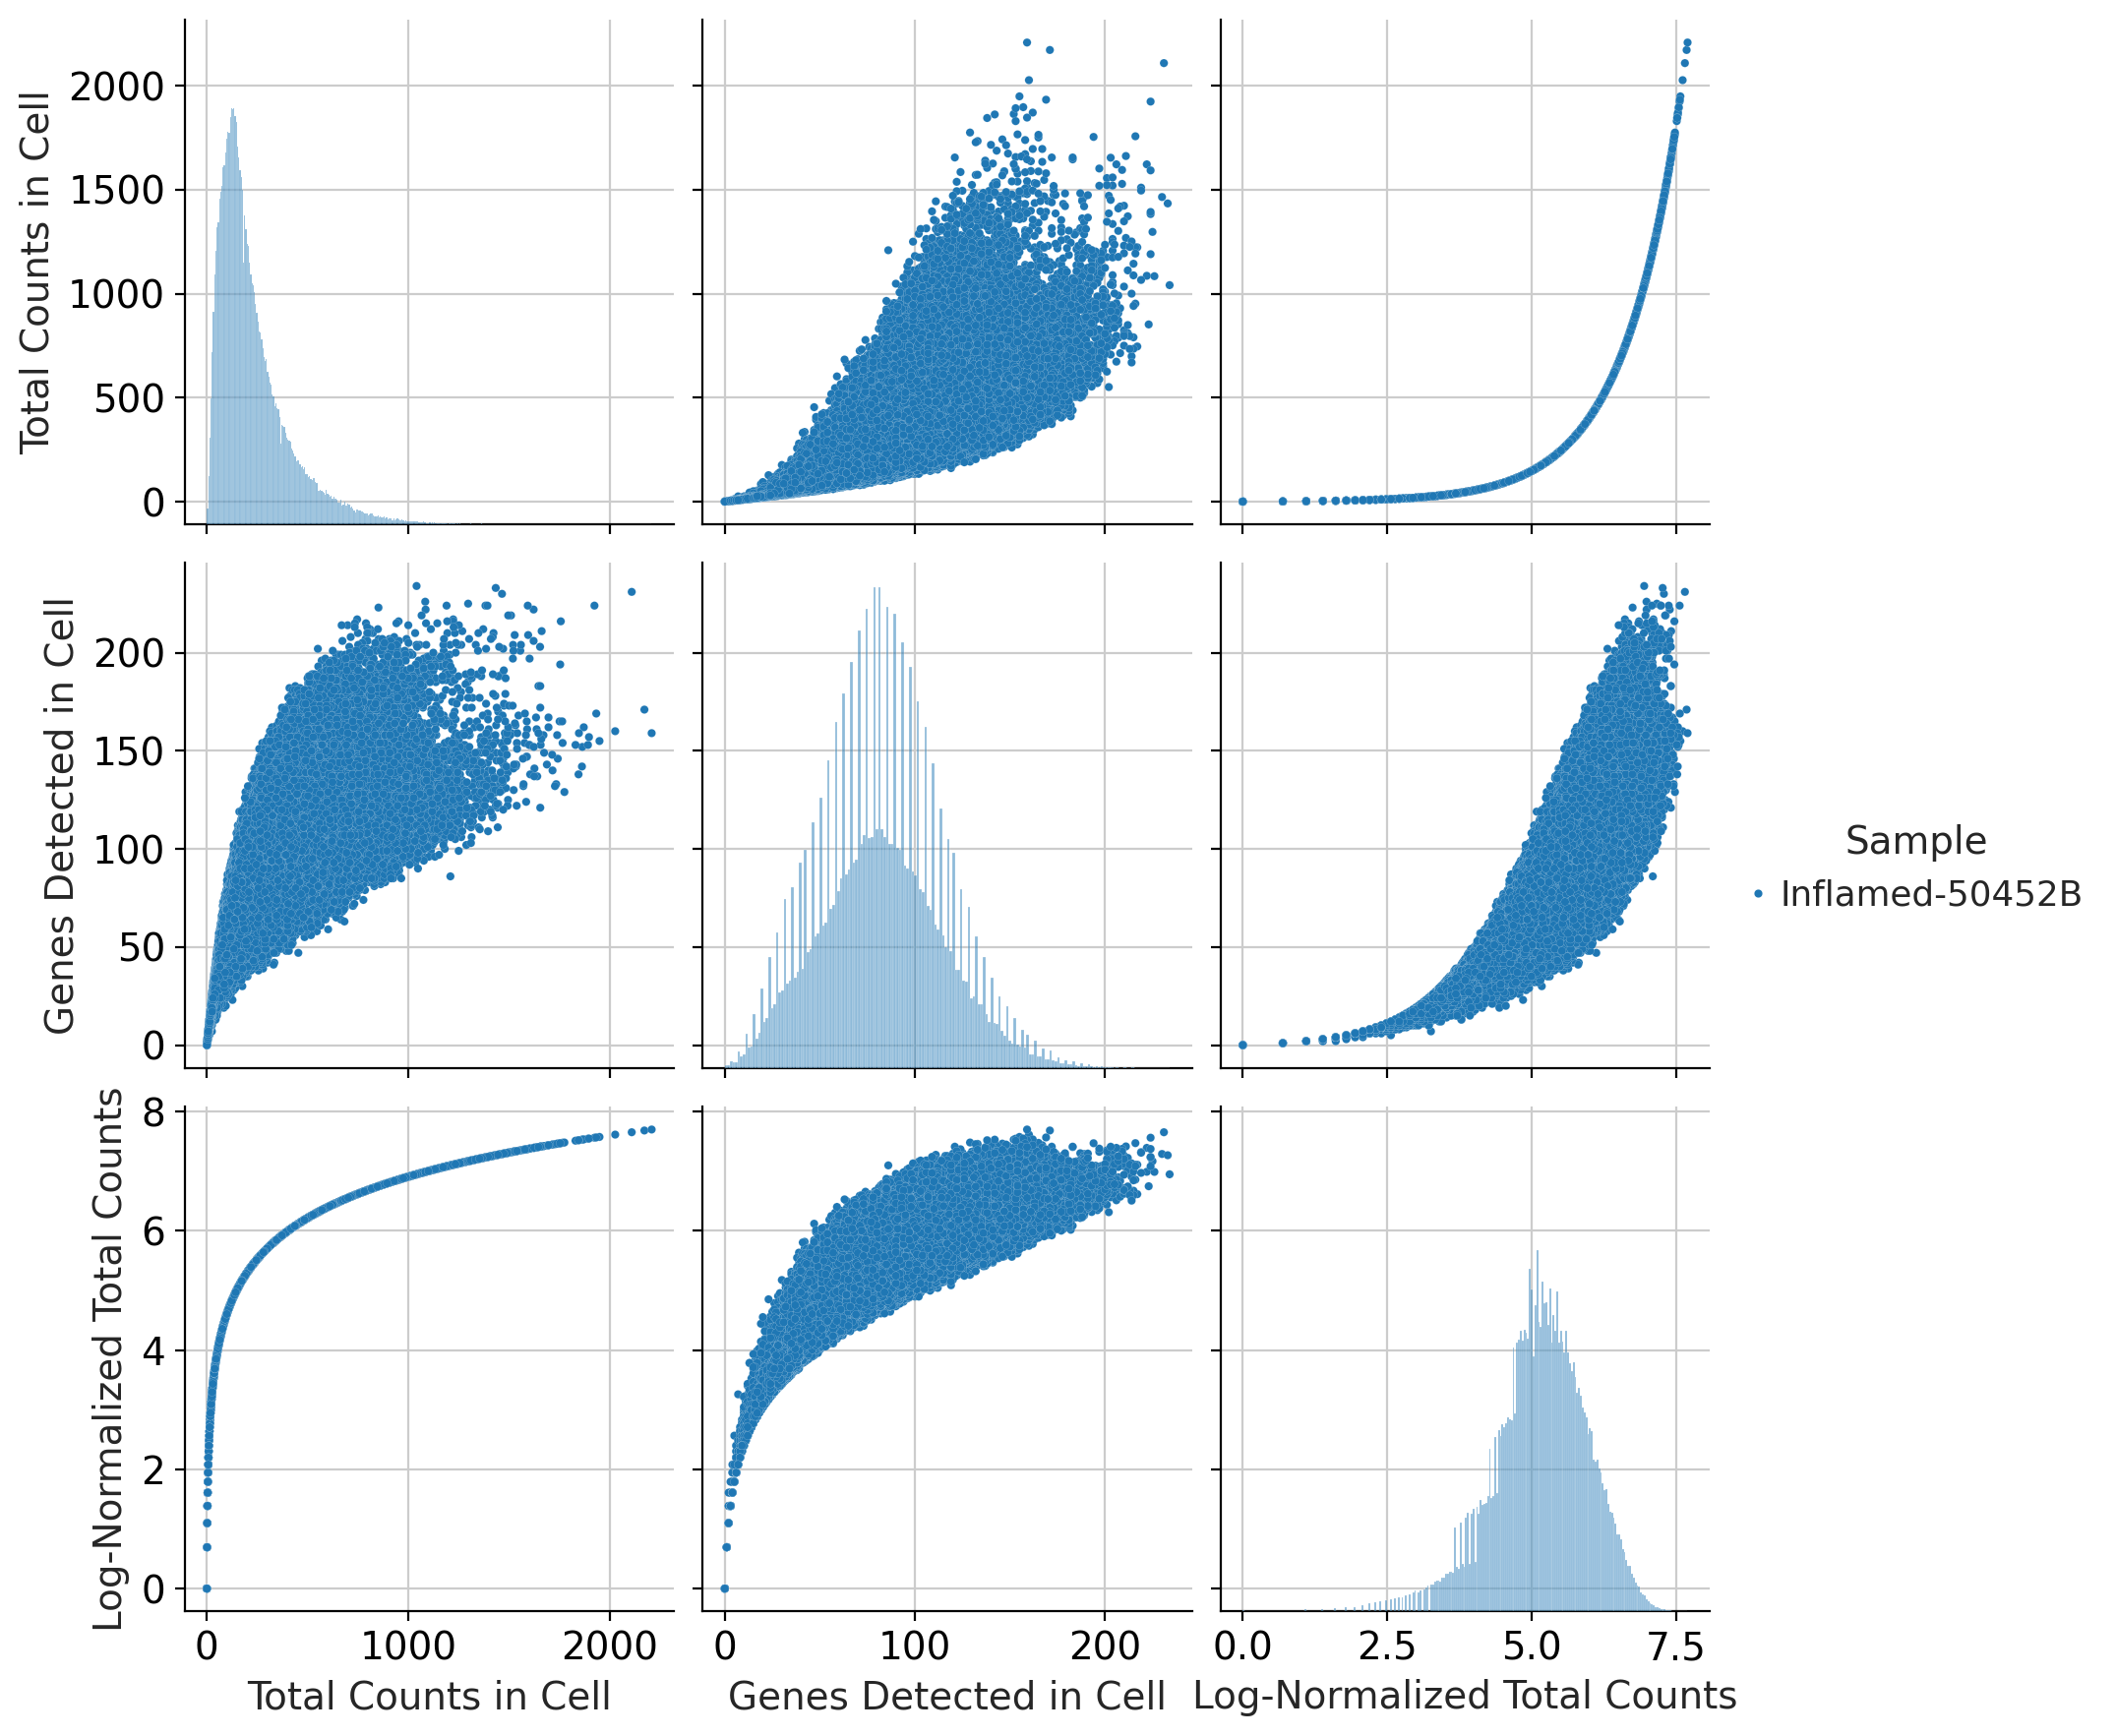

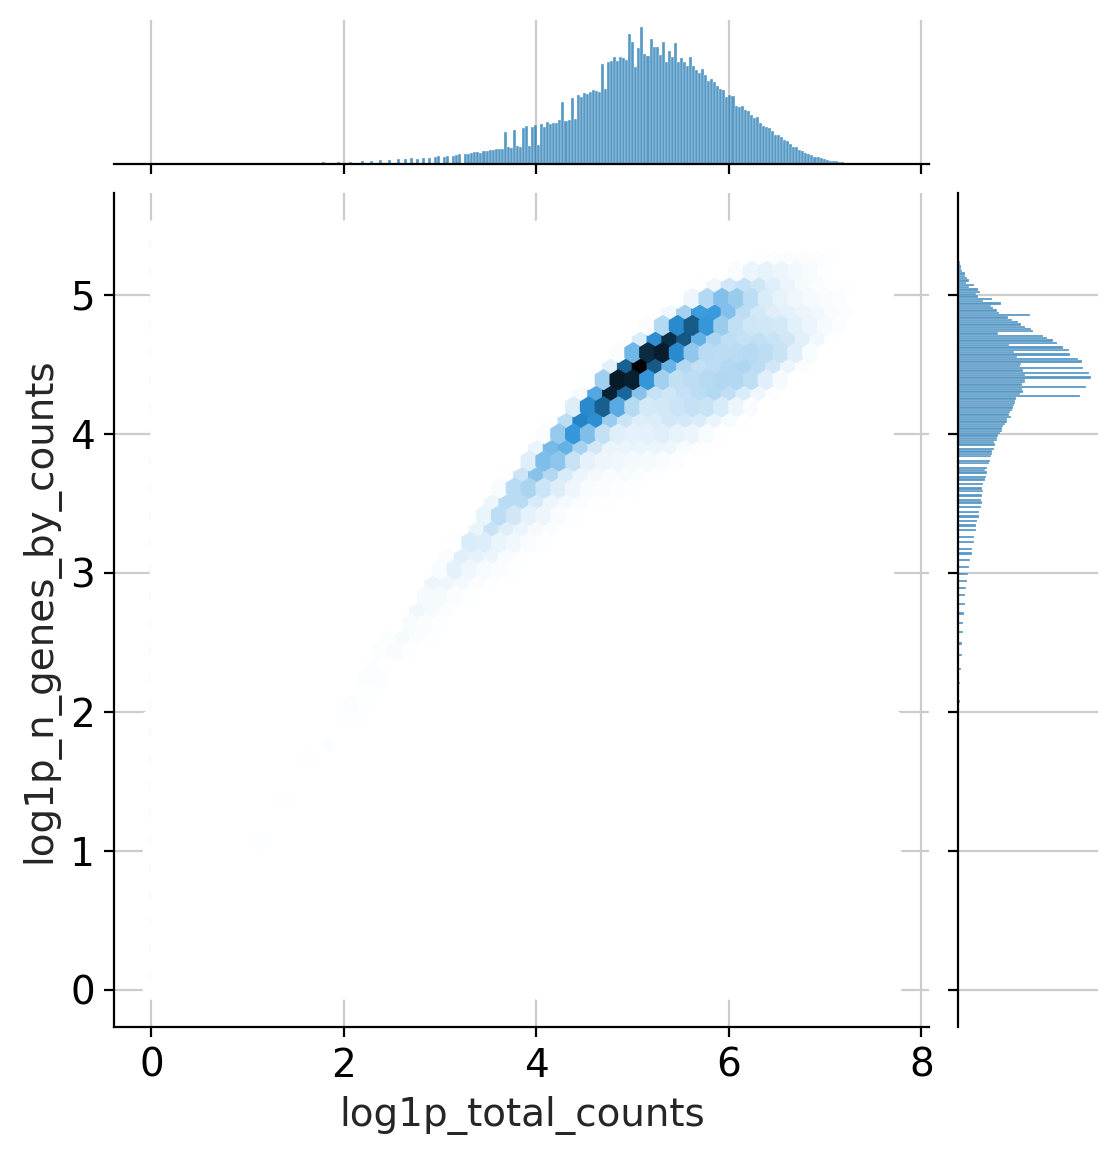

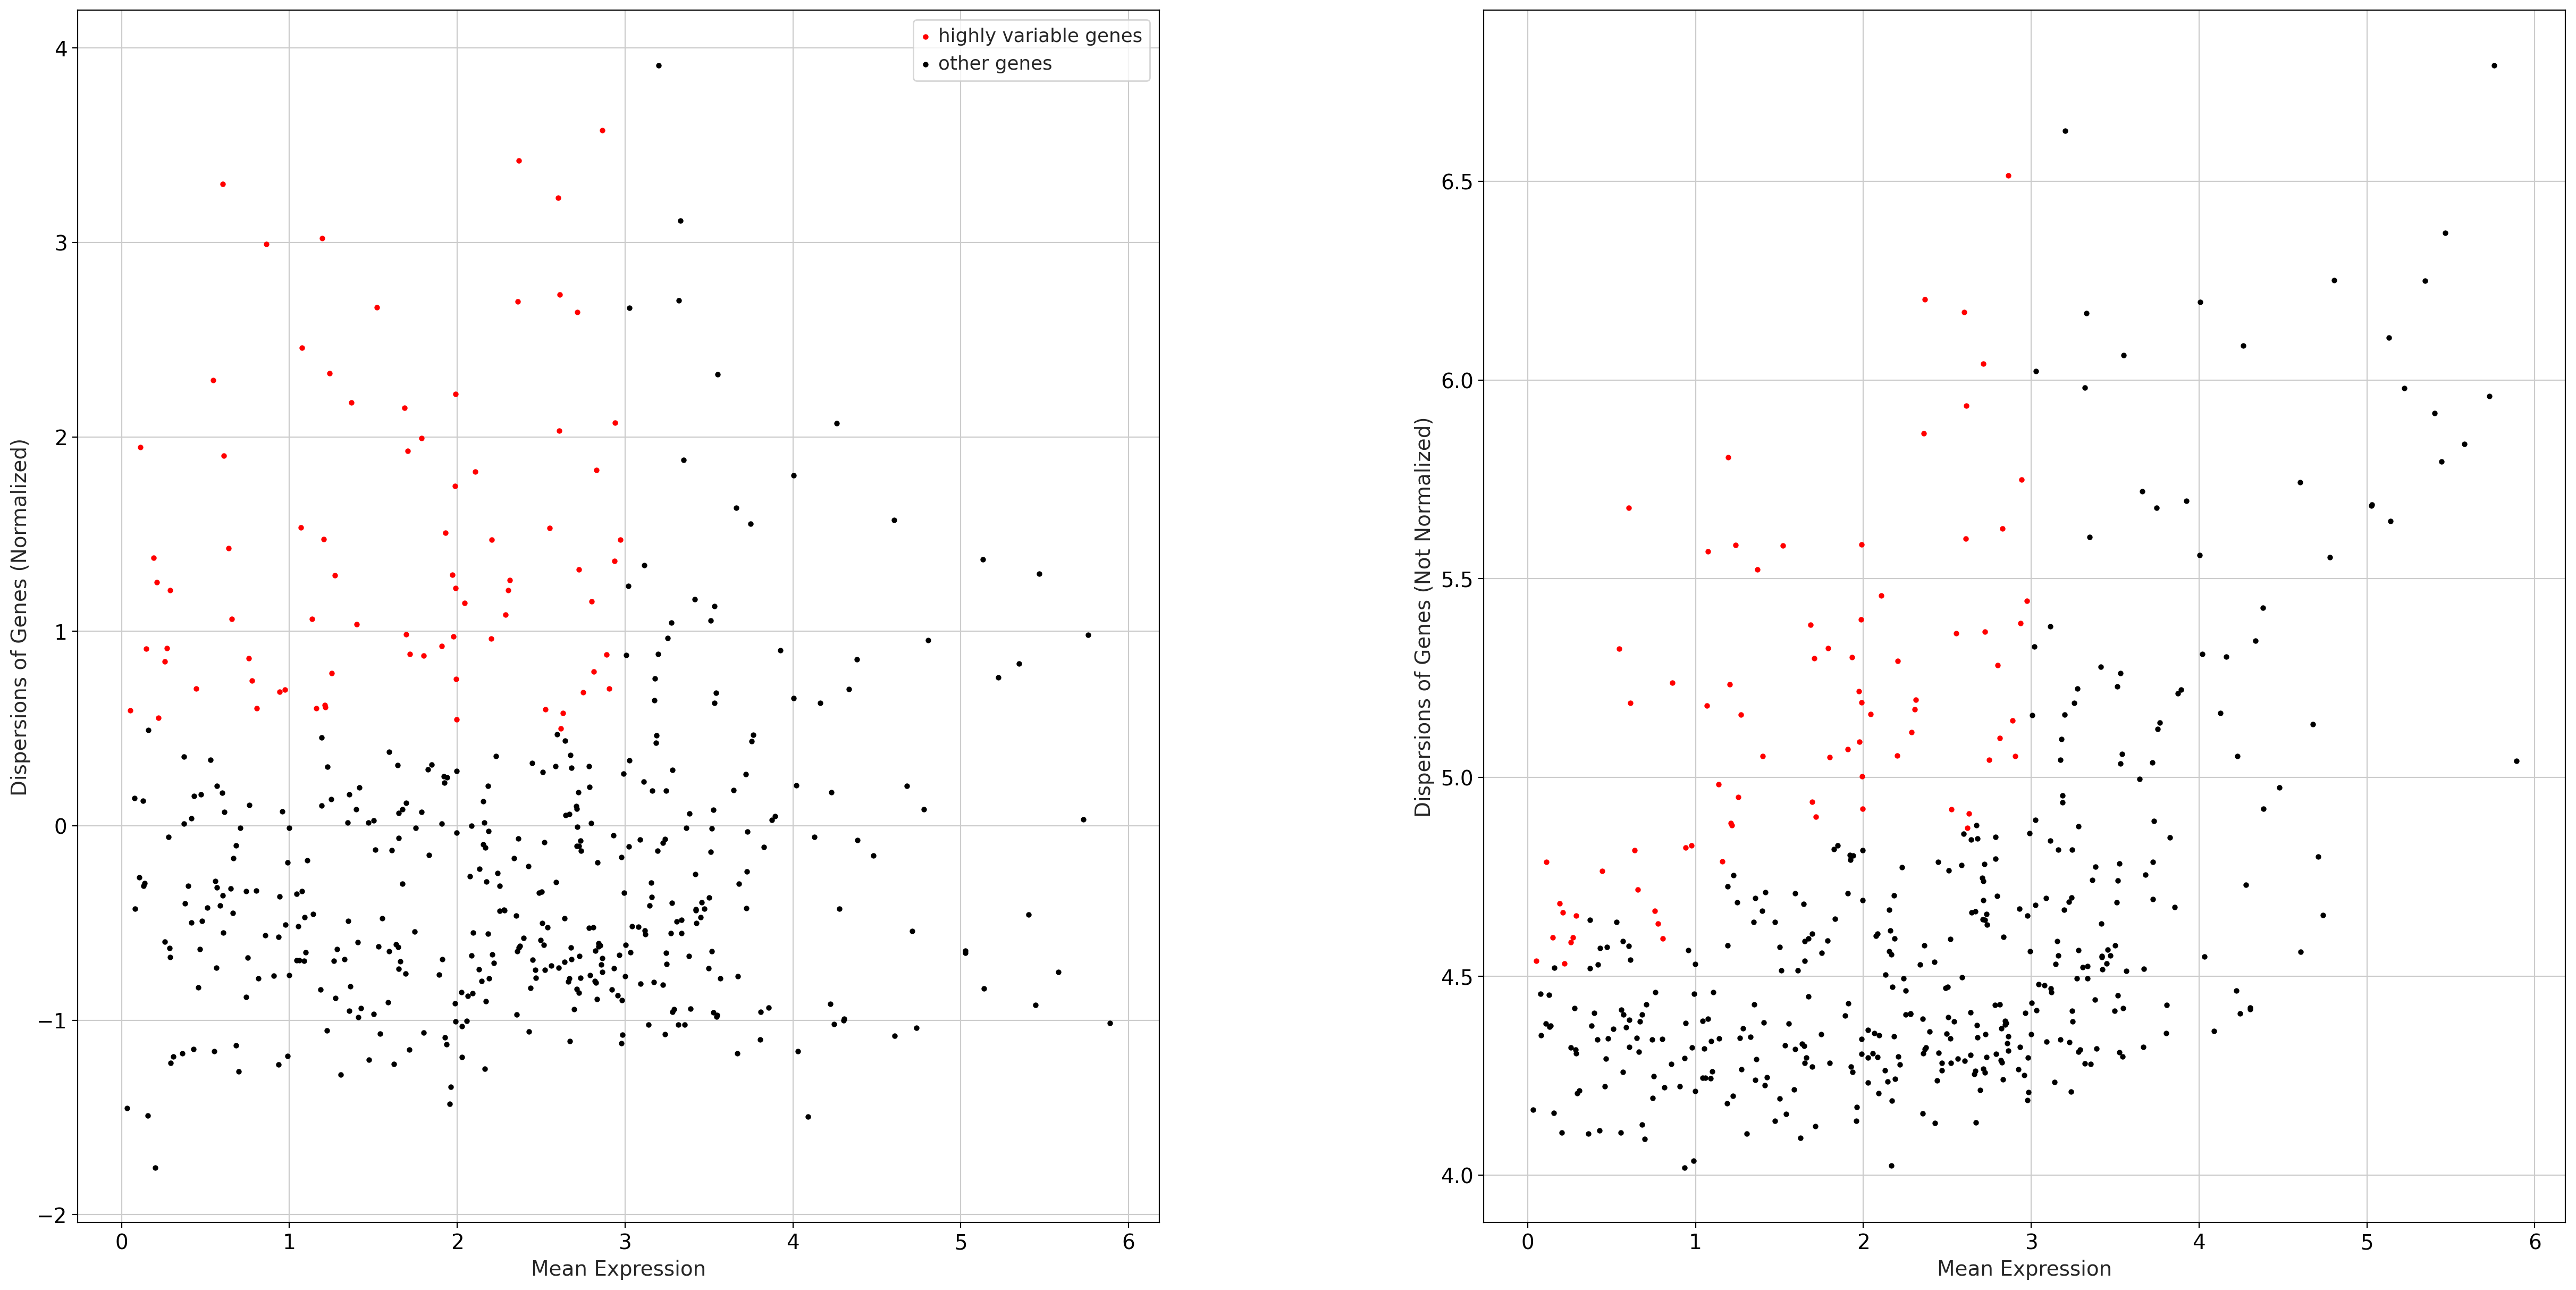


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...
dsfasfda AnnData object with n_obs × n_vars = 257679 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Location', 'Stricture', 'Inflamed', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Condition', 'file_path', 'out_file', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 

ValueError: Could not find marker gene data. Please run `sc.tl.rank_genes_groups()` first.

In [29]:
%%time

print("\n\n", kws_pp, "\n\n")
for i, s in enumerate(selves):
    f_o = str(selves[0].rna.obs.out_file.iloc[0])

    # Preprocessing
    if load is False:
        _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess

    # Clustering at Different Resolutions & Minimum Distances
    for j, x in enumerate(kws_clustering):

        # Variables & Output Files
        print(kws_clustering[x])
        cct, cca, f_i = f"leiden_{x}", f"label_{x}", f"{s._library_id}_{x}"
        f_m = f"{f_o}__{cct}_markers.csv" if out_dir else None
        annot = assign[[col_assignment[j]]]

        # Clustering
        if load is False:
            _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        if load is False or f"rank_genes_groups_{cct}" not in s.rna.uns:
            _ = s.find_markers(col_cell_type=cct, kws_plot=False)
        if reannotate is True or load is False:
            _ = s.annotate_clusters(annot, col_cell_type=cct,
                                    col_annotation=cca)
        if load is False or reannotate is True:  # write Explorer files
            for c in [k for k in [cct, cca] if k in s.rna.obs]:
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                 file_prefix=f"{s._library_id}__", n_top=True)

    # Write Final Object
    if load is False or reannotate is True and f_o is not None:
        s.write(f_o)

In [52]:

            _ = s.annotate_clusters(annot, col_cell_type=cct,
                                    col_annotation=cca)

In [40]:
kws_clustering, col_assignment = {}, []
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})
    col_assignment += ["group" if kws["resolution"] >= 0.7 else "Bucket"]

In [41]:
        assign_old, c_a = assign.copy(), col_assignment
        col_assignment = col_assignment[0]
        adata = self.rna.copy()
        assign = anf[[col_assignment]]

        assign = assign.rename_axis("Gene")
        assign.columns = [col_assignment]
        assign = dict(assign.reset_index().groupby(col_assignment).apply(
            lambda x: list(pd.unique(x.Gene))))  # to marker dictionary
        overlap = sc.tl.marker_gene_overlap(
            adata, assign, method=method, key_added=key_add,
            top_n_markers=n_top, **kwargs)  # overlap scores
        overlap = overlap.T.join(overlap.apply(lambda x: overlap.index.values[
            np.argmax(x)]).to_frame(col_new))

        assign, col_assignment = assign_old, c_a

NameError: name 'method' is not defined

In [46]:
        method = "overlap_count"
        key_add = f"rank_genes_groups_{cct}"
        n_top = 10
        kwargs = {}
        col_new = cca

        overlap = sc.tl.marker_gene_overlap(
            adata, assign, method=method, key_added=key_add,
            top_n_markers=n_top, **kwargs)  # overlap scores
        overlap = overlap.T.join(overlap.apply(lambda x: overlap.index.values[
            np.argmax(x)]).to_frame(col_new))

        assign, col_assignment = assign_old, c_a

## Tangram Imputation

In [ ]:
if file_sc is not None:
    adata_sc = sc.read(file_sc)  # read whole tx'ome data for imputation
    if load is False:
        for i, s in enumerate(selves):
            _ = s.impute(
                adata_sc.copy(), col_cell_type=col_cell_type_sc,
                mode="clusters", markers=None, plot=False, plot_density=False,
                plot_genes=None, col_annotation=col_tangram, out_file=None)
            s.write(str(selves[0].rna.obs.out_file.iloc[0]))
            s.write_clusters(out_dir, col_cell_type=col_tangram,
                             overwrite=True,
                             file_prefix=f"{s._library_id}__", n_top=True)
    s.plot_spatial(color=col_tangram)

In [ ]:
for s in selves:
    s.write_clusters(out_dir, col_cell_type=col_tangram, overwrite=True,
                     file_prefix=f"{s._library_id}__", n_top=True)
    s.write(str(selves[0].rna.obs.out_file.iloc[0]))
    s.plot_spatial(color=col_tangram)

## Plot Clusters

In [ ]:
for s in selves:
    s.plot_spatial(color=col_tangram)
    for j, x in enumerate(kws_clustering):
        _ = s.plot_spatial(color=[f"leiden_{x}",, f"label_{x}"])

# Set Cell Type Column

In [ ]:
for s in selves:
    s._columns[col_cell_type] = "leiden_res0pt5_dist0pt5_npc30"

# Analyze

## Centrality Scores

In [ ]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Spatial Clustering

In [ ]:
for s in selves:
    _ = s.cluster_spatial(key_added="leiden_spatial")

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=genes, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 10), top_n=25, key_sources=kss, key_targets=ktt)
    # s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## GEX

In [ ]:
for s in selves:
    s.plot_spatial(color=["TNF", "IL23", col_cell_type])

In [ ]:
_ = self.calculate_spatial_distance("LTi-like NCR+ ILC3", genes="CSF2RB")

In [ ]:
adata.X = adata.layers["counts"]
sq.tl.var_by_distance(
    adata, "LTi-like NCR+ ILC3", col_cell_type, library_key=col_sample_id,
    design_matrix_key="design_matrix", covariates=["Patient", "Inflamed"],
    metric="euclidean", spatial_key=self._spatial_key, copy=False)
sq.pl.var_by_distance(
    adata=adata, var=["CSF2RB", "CSF2RA", "IL7R"],
    anchor_key="LTi-like NCR+ ILC3",
    covariate="Inflamed")